# Collaborative filtering

## Load libraries

In [1]:
import pandas as pd
import dexplot

## Read data

In [2]:
ratings = pd.read_csv('./goodbooks-10k-1.0/ratings.csv')
#books = pd.read_csv('./goodbooks-10k-1.0/books.csv')
display(ratings.head(5))

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [3]:
print(f'Number of ratings is {len(ratings)}')
print(f'Number of users who rated at least one book is {len(ratings.user_id.unique())}')

Number of ratings is 5976479
Number of users who rated at least one book is 53424


There is almost a 6 million ratings - it would be hard to process such an amount of data. We have to reduce the number of observations.

Let's see the statistics for number of books rated per user:

In [4]:
def grouping(data, col_name):
    return data.groupby(col_name)['rating'].count()

In [5]:
def check_ratings(data, col_name):
    data_grouped = grouping(data, col_name)
    title = 'Number of ratings per '+ str(col_name[:-3])
    display(dexplot.hist(val='rating',data=data_grouped, title=title, cmap='plasma'))
    print('Statistics for dataframe grouped by '+ str(col_name) +':')
    print(data_grouped.describe())

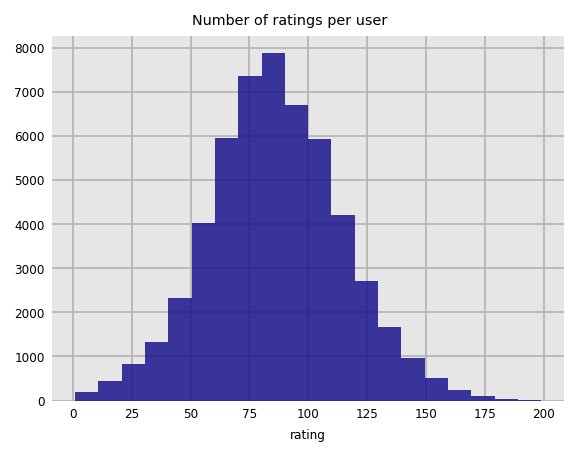

Statistics for dataframe grouped by user_id:
count    53424.000000
mean        86.366745
std         28.334976
min          1.000000
25%         68.000000
50%         86.000000
75%        104.000000
max        199.000000
Name: rating, dtype: float64


In [69]:
check_ratings(ratings, 'user_id')

Let's remove users which rated less than 100 books.

In [9]:
grouped_by_user = grouping(ratings, 'user_id')

In [10]:
ratings = ratings[ratings.user_id.isin(grouped_by_user[grouped_by_user >=120].index)]

In [11]:
ratings

,user_id,book_id,rating
12,4,70,4
13,4,264,3
14,4,388,4
15,4,18,5
16,4,27,5
...,...,...,...
5976353,50480,1688,3
5976354,50480,2216,4
5976355,50480,1539,3
5976356,50480,2772,4


Let's see the statistics for number of ratings per book:

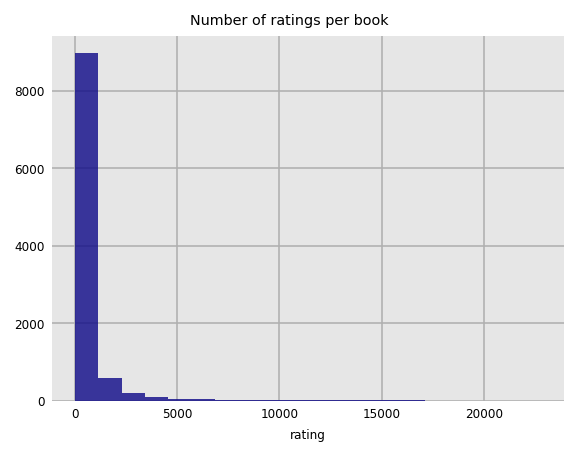

Statistics for dataframe grouped by book_id:
count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
Name: rating, dtype: float64


In [65]:
check_ratings(ratings, 'book_id')

Let's remove books which has less than 248 reviews.

In [6]:
grouped_by_book = grouping(ratings, 'book_id')

In [7]:
ratings = ratings[ratings.book_id.isin(grouped_by_book[grouped_by_book >=400].index)]

In [68]:
ratings

,user_id,book_id,rating
0,1,258,5
2,2,260,5
5,2,26,4
6,2,315,3
7,2,33,4
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


In [13]:
import random

In [14]:
random.seed(6)

Check if there are any NaNs in data

In [15]:
ratings.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

Check if there is any users who give two ratings to the same book.

In [16]:
ratings.duplicated(['user_id','book_id']).sum()

0

In [17]:
ratings.rating.describe()

count    849199.000000
mean          3.857025
std           1.010149
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [18]:
print(f'Total number of users is {len(ratings.user_id.unique())}.')
print(f'Total number of rated books is {len(ratings.book_id.unique())}.')
print(f'Total number of ratings is {len(ratings)}.')

Total number of users is 6280.
Total number of rated books is 3164.
Total number of ratings is 849199.


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


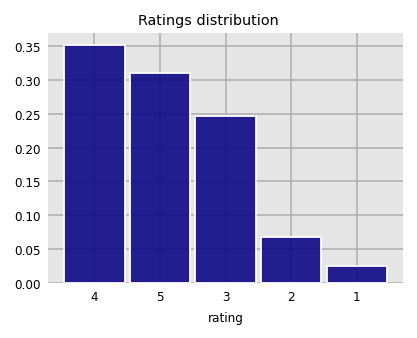

In [19]:
dexplot.count(val='rating', data=ratings, normalize= True, title='Ratings distribution', cmap='plasma')

The most common rating is 4. Now we have to check if there are any books with really few ratings or users who gave very few ratings.

In [20]:
def check_ratings(data, col_name):
    data_grouped = data.groupby(col_name)['rating'].count()
    title = 'Number of ratings per '+ str(col_name[:-3])
    display(dexplot.hist(val='rating',data=data_grouped, title=title, cmap='plasma'))
    print('Statistics for dataframe grouped by '+ str(col_name) +':')
    print(data_grouped.describe())

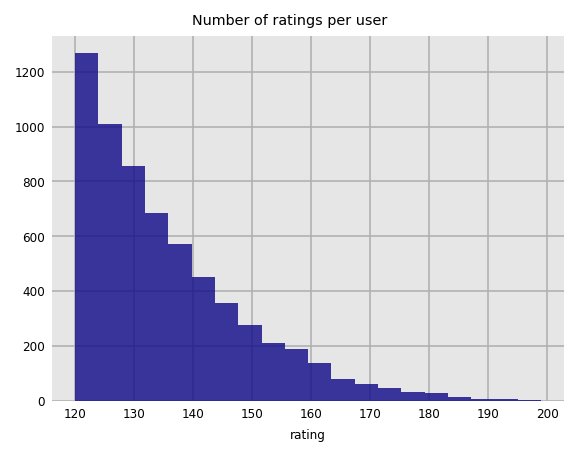

Statistics for dataframe grouped by user_id:
count    6280.000000
mean      135.222771
std        13.544941
min       120.000000
25%       125.000000
50%       132.000000
75%       142.000000
max       199.000000
Name: rating, dtype: float64


In [21]:
check_ratings(ratings,'user_id')

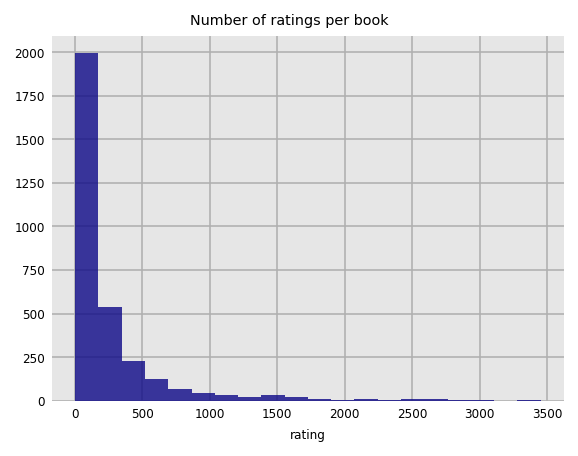

Statistics for dataframe grouped by book_id:
count    3164.000000
mean      268.394121
std       416.501205
min         1.000000
25%        65.000000
50%       121.000000
75%       267.500000
max      3452.000000
Name: rating, dtype: float64


In [22]:
check_ratings(ratings,'book_id')

For the prediction I will use the library Surprise.

In [23]:
from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import KNNBasic,KNNBaseline,KNNWithZScore,KNNWithMeans
from surprise import accuracy
import random

In [24]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)
raw_ratings = data.raw_ratings
train = data

In [25]:
random.shuffle(raw_ratings)

Divide data into train and test

In [26]:
train_size = int(.9 * len(raw_ratings)) 
train_raw_ratings = raw_ratings[:train_size]                             
test_raw_ratings = raw_ratings[train_size:]                                 
train.raw_ratings = train_raw_ratings

In [27]:
model_list = [KNNBasic,KNNBaseline,KNNWithZScore,KNNWithMeans]
param_grid = {'k': [40, 50, 60], 
              'sim_options': {'name' : ['cosine','msd', 'pearson']
                              ,'user_based': [True, False]}
             }
results = []

In [ ]:
for model in model_list:
    grid = GridSearchCV(model,param_grid, cv = 10)
    grid.fit(train)
    print(f' Best params for model {str(model)} are {grid.best_params_}')
    results.append((str(model)[:-2],model))

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:


models = []
models.append(('SVM rbf', grid_1.best_estimator_))
models.append(('XGBoost', grid_2.best_estimator_))
models.append(('RF', grid_3.best_estimator_))
models.append(('ExtraTrees', grid_5.best_estimator_))
models.append(('AdaBoost', grid_6.best_estimator_))


rmse = []
p_cos = []
f1_score = []
accuracy_score = []
for name, model in model_list:
    print(name)
    print("R^2: {}".format(metrics.precision_score(y_test, model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test, model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test, model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test, model.predict(X_test)) ))
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))

In [ ]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['SVM rbf','XGBoost','RF','ExtraTrees','Adaboost'])
df